### from PMPP book 

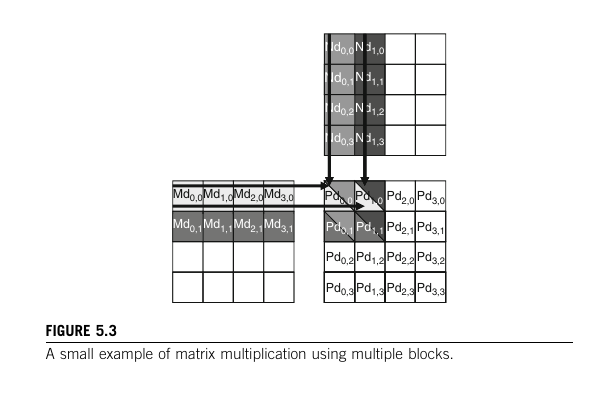

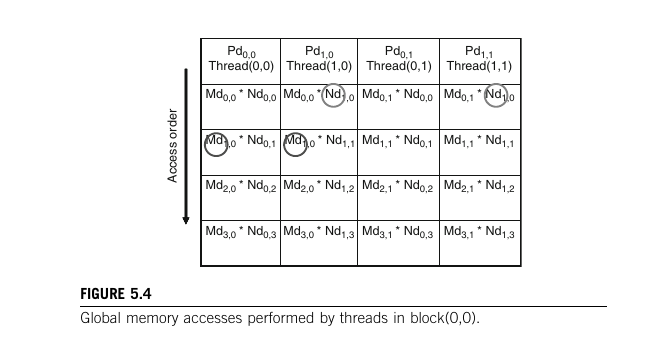

With fp16 data type (2B each) and assuming 2 consecutive matrix elements will share a 4B wide shared memory bank, there are bank conflicts for the following consecutive elements: 
$Md_{00}, Md_{01}, Nd_{00}, Nd_{10}$ in the first access only so there are bank conflicts at almost every access stage without padding. 
But with the tile size of 128 * 64 for matrix A, padding by 8 means that each row of the tile of matrix A will start at an offset of 16B (8 * 2B) and since the shared memory is composed of 32 banks of 4B each totaling 128B, this will wrap around after 8 rows of matrix A’s tile which means it wraps twice for each 16 * 16 dimension of the warp tile.  

Ie. $Md_{00}$ is in the first bank and $Md_{01}$ would be in the 5th bank (4 banks before it) after padding where as before both would have been in the first bank causing a bank conflict.  

Referring to Listing 2 in the paper, we can see that the tile for matrix A is loaded in row major order:

### mappings for the loop iterations
```mlir
#map0 = affine_map<(d0) -> (d0)>
#map1 = affine_map<(d0) -> (d0 + 64)>
#map2 = affine_map<(d0) -> (d0 + 128)>
```

```mlir
// Copy loop for A. tile dim of 128 * 64 or 128 * (64+8) after padding
affine.for %copyii = #map0(%i) to #map2(%i) {  //128
  affine.for %copykk = #map0(%k) to #map1(%k) { //64
    %11 = affine.load %A[%copyii, %copykk] : memref<8192x8192xf16>
    affine.store %11, %a_smem[%copyii - %i, %copykk - %k] : memref<128x72xf16, 3>
  }
}
```

So now accesses to $Nd_{00}$ and $Nd_{10}$ will not be a bank conflict as $Nd_{00}$ is in the first bank and $Nd_{10}$ is staggered by 8 * 2B = 16B meaning it is in the 5th bank (has 4 banks in front of it). 

Then if the tile of matrix B is loaded in row major order as well meaning there is spillage of the first row of 128 2B elements into the second row since 128 * 2B = 256B, clearly larger than the 32 4B banks (128B) can hold, in fact one row of tile B takes up two logical rows of the shared memory.  Then it is padded by 8 elements or 16B (8 * 2B) which again offsets by 4 banks (16 `div` 4) and again every 8 rows will be back to starting in the first bank.  

```mlir
// Copy loop for B, tile dim of 64 * 128 or 64 * (128 + 8) after padding
affine.for %copykk = #map0(%k) to #map1(%k) { //64
    affine.for %copyjj = #map0(%j) to #map2(%j) { //128
        %11 = affine.load %B[%copykk, %copyjj] : memref<8192x8192xf16>
        affine.store %11, %b_smem[%copykk - %k, %copyjj - %j] : memref<64x136xf16, 3>
    }
}
```

### can I load the tiles of matrix B in column major logical order in shared memory?  

That would make the dimensions quite similar to the matrix A tile of 64 * 128 and again could use a similar padding factor to have the offsets between 16B and 112B, reverting to 0 every 8th row.  

Then as I'll mention below, I can prepend the tile for matrix B with a pad to solve my bank conflict on my sm_75?



### Bank conflict remains (in my mind at least...) 

Even with the scheme to pad the leading dimension by 8 elements we still get a bank conflict for Md_00 and Nd_00 as they both would be in the first bank although separated by many logical rows.  

### The authors state padding factor can be any multiple of 8.  

On my sm_75 with 32 banks, I want to try offsetting the first logical row of shared memory for the tile of matrix B by multiples of 8 (8 * 2B = 16B). 
